In [1]:
import os
import sys
os.chdir("../../../")
import numpy as np
import pandas as pd


from src.tourism.mtsmodel import VARPipeline

/Users/czhang/miniforge3/envs/bayes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2023-12-22 15:47:45 - prophet.plot:39 - ERROR] Importing plotly failed. Interactive plots will not work.


In [2]:
seed = sum(map(ord, "PyMC LABS - BVAR"))
rng = np.random.default_rng(seed=seed)

In [3]:
mts = VARPipeline(country="samoa",
                  y_var=["total", "seats_arrivals_intl"],
                  exog_var=["covid", "stringency_index", "samoa_travel"],
                  training_ratio=0.95)
mts.read_and_merge()
d = mts.data[mts.data.date >= "2019-01-01"].reset_index(drop=True).dropna()

In [116]:
data = d[["total", "seats_arrivals_intl"]]

In [120]:
lags = 2

coords={
    "lags": reversed(range(-lags, 0)),
    "vars": ("total", "seats_arrivals_intl"),
    "cross_vars": ("total", "seats_arrivals_intl"),
    "exog_vars": ("samoa_travel"),
    "time": range(len(data) - lags),
}

with pm.Model(coords=coords) as BVAR_model:
    # The first B bit:
    # Priors for the model intercept, lagged coefficients and noise terms
    intercept = pm.Normal("intercept", mu=0, sigma=1, dims=("vars",))
    lag_coefs = pm.Normal("lag_coefs", mu=0, sigma=1, dims=("lags", "vars", "cross_vars"))
    exog_coefs = pm.Normal("exog_coefs", mu=0, sigma=1, dims=("exog_vars",))
    noise = pm.HalfNormal("noise", dims=("vars",))

    # The VAR bit:
    # Compute autoregressive expectation for each variable
    # We convolve the lagged coefficients of each variable with the whole dataset
    ar_GDPGrowth = pm.math.sum([
        pm.math.sum(lag_coefs[i, 0] * data.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)        
    ar_TSpread = pm.math.sum([
        pm.math.sum(lag_coefs[i, 1] * data.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)   

    # Stack autoregressive terms and add intercepts
    mean = intercept + pm.math.stack([ar_GDPGrowth, ar_TSpread], axis=-1) + exog_vars 

    # The second B bit:
    # For modelling simplicity, we ignore the first observations, where we could
    # not observe the effects of all the lagged coefficients
    obs = pm.Normal("obs", mu=mean, sigma=noise, observed=data[lags:], dims=("time", "vars"))

In [118]:
with BVAR_model:
    trace = pm.sample(chains=4, random_seed=rng)

In [119]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

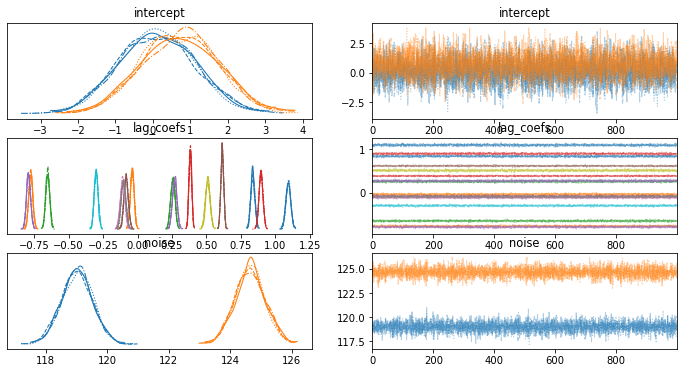

In [100]:
import arviz as az
az.plot_trace(trace);

In [83]:
# Function that takes a single draw of parameters and forecasts n steps
def _forecast(intercept, lag_coefs, noise, forecast=5):
    len_data = len(data)
    new_draws = np.zeros((data.shape[0]+forecast, data.shape[1]))
    # Fill the new array with the observed data
    new_draws[:len_data] = data[:]
    for i in range(forecast):
        ar_GDPGrowth = np.sum(lag_coefs[:, 0] * new_draws[len_data+i-lags: len_data+i])
        ar_TSpread = np.sum(lag_coefs[:, 1] * new_draws[len_data+i-lags: len_data+i])
        mean = intercept + np.stack([ar_GDPGrowth, ar_TSpread])
        new_draws[len_data+i] = rng.normal(mean, noise)
    # Replace all observed data with nan, so they don't show when we plot it
    new_draws[:-forecast-1] = np.nan
    return new_draws

# Vectorized forecast function to handle multiple parameter draws
forecast = np.vectorize(
    _forecast,
    signature=("(v),(l,v,v),(v)->(o,v)"),
    excluded=("forecast",),
)

In [84]:
draws = rng.integers(4000, size=100)

post = trace.posterior.stack(sample=("chain", "draw"))
intercept_draws = post["intercept"].values.T[draws]

lag_coefs_draws = post["lag_coefs"].values.T[draws].T
lag_coefs_draws = np.moveaxis(lag_coefs_draws, -1, 0)

noise_draws = post["noise"].values.T[draws]

intercept_draws.shape, lag_coefs_draws.shape, noise_draws.shape

((100, 2), (100, 2, 2, 2), (100, 2))

In [91]:
ppc_draws = forecast(intercept_draws, lag_coefs_draws, noise_draws, forecast=5)
ppc_draws = np.swapaxes(ppc_draws, 0, 1)

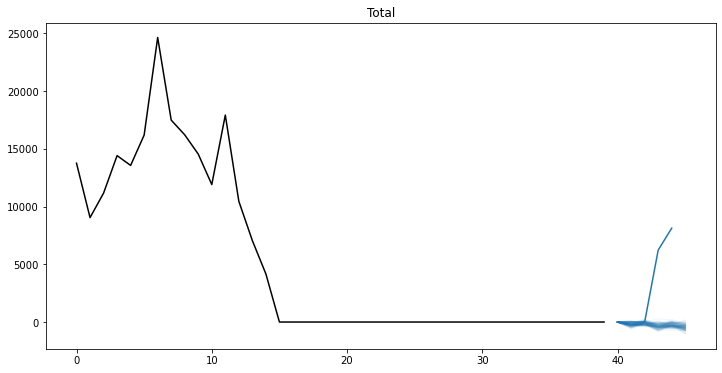

In [97]:
_, ax = plt.subplots(figsize=(12,6))

ax.set_title("Total")
ax.plot(range(1,46), ppc_draws[..., 0], color="C0", alpha=0.05)
ax.plot(data["total"], color="k", label="observed")
ax.plot(d["total"][40:], color="C0", label="forecast")
